# Weak Supervision

In this notebook, we will discuss the concept of weak supervision in the context of anomaly detection. It will define what is often referred to as an *idealized anomaly detector* and compare it to a fully supervised classifier. The end of the notebook also has some macros for plotting the performance of multiple retrainings in terms of median and 68% confidence intervals.

The usual approach to find a powerful discriminant for distinguishing two classes of data (here signal and background) from each other, is to train a machine learning classifier (e.g. a neural network) to distinguish the classes from each other, based on some input features $x$. At each training iteration, we compare the output of the classifier $f(x)$ to the actual label $y$ (1 for signal, 0 for background) of the training data via the loss function (usually binary cross entropy) and optimize the weights of the classifier such that they match as well as possible. What the classifier learns then is to approximate the likelihood ratio $\frac{p_{sig}}{p_{bkg}}$, which is the most powerful test statistic according to the Neyman Pearson Lemma. This *fully supervised classifier* relies on knowing a-priori which training data are signal and which are background during training.

However, there might be cases where one does not have such truth labels in advance. A prominent case is anomaly detection where one searches for small hints of anomalous signal within an overwhelming background, in a model-agnostic way. Let's imagine the case that we only have our measured data, that consists of background and maybe some signal. In addition, we somehow got an extra sample of just background data. If that was the case, we could just train a classifier to distinguish these two classes (data=sig+bkg vs bkg). Our classifier would approach a likelihood ratio that is monotonically linked to the signal-vs-bkg one $\frac{p_{(sig+bkg)}}{p_{bkg}} = \frac{f_{sig} p_{sig} + (1- f_{sig}) p_{bkg}}{p_{bkg}} = f_{sig} \frac{p_{sig}}{p_{bkg}} + (1 - f_{sig})$ where $f_{sig}$ is the (unknown) signal fraction in the data.

The question is now where to get this magic background-only sample. One might have a very good Monte Carlo simulation, or one might instead generate it in-situ via some data-driven estimate. The latter is the approach that multiple weak supervision methods take, such as [CWoLa Hunting](https://arxiv.org/abs/1902.02634), [SALAD](https://arxiv.org/abs/2212.10579), [CATHODE](https://arxiv.org/abs/2109.00546), [CURTAINS](https://arxiv.org/abs/2203.09470), [FETA](https://arxiv.org/abs/2212.11285). For now, we just assume we already have such a large background-only sample and refer to this idealization as the *idealized anomaly detector* (IAD).

Here, we first illustrate the fully supervised training and will then compare it to the IAD.

In [1]:
!pip install vector scikit-learn==1.4.0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys

from os.path import exists, join, dirname, realpath
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier

In [3]:
# :sunglasses:
plt.style.use('dark_background')

The input data are preprocessed via another script `demos/utils/data_preparation.py`. It downloads the [LHCO R\&D dataset](https://zenodo.org/records/4536377) and applies the preprocessing to extract the conditional feature $m=m_{jj}$ and four auxiliary features $x=(m_{j1}, \Delta m_{jj}, \tau_{21,j1}, \tau_{21,j2})$. Morevoer, it divides the $m$ spectrum into signal region and sidebands, and splits the data into training/validation/test sets. Furthermore, it consists of extra background-only samples, which we will make use of here, as well as an extra signal sample, which we will use in supervised training and for the common test set. By default, there are approximately 0.6% signal events in the "data".

For the purpose of this guide, we will only use the signal region, as the sideband is typically used to estimate the background-only sample in realistic weak supervision methods. Further, we will not use the "conditional feature" $m_{jj}$ for the training, even though this would be possible.

In [4]:
data_path = "/global/cfs/cdirs/ntrain1/anomaly/input_data/"

In [5]:
# data preparation (download and high-level preprocessing)
if not exists(join(data_path, "innerdata_test.npy")):
    process = subprocess.run(f"{sys.executable} {join(parent_dir, 'demos', 'utils', 'data_preparation.py')} --outdir {data_path}", shell=True, check=True)

In [6]:
# data loading
innerdata_train = np.load(join(data_path, "innerdata_train.npy"))
innerdata_val = np.load(join(data_path, "innerdata_val.npy"))
innerdata_test = np.load(join(data_path, "innerdata_test.npy"))
innerdata_extrabkg_train = np.load(join(data_path, "innerdata_extrabkg_train.npy"))
innerdata_extrabkg_val = np.load(join(data_path, "innerdata_extrabkg_val.npy"))
innerdata_extrabkg_test = np.load(join(data_path, "innerdata_extrabkg_test.npy"))
innerdata_extrasig = np.load(join(data_path, "innerdata_extrasig.npy"))

# splitting up the extra signal into train/val proportionally
# also leaving some for the test set
innerdata_extrasig_test = innerdata_extrasig[:20000]
innerdata_extrasig_train, innerdata_extrasig_val = train_test_split(innerdata_extrasig[20000:],
                                                                    train_size=len(innerdata_train)/(len(innerdata_train)+len(innerdata_val)),
                                                                    random_state=42)

The supervised classifier would realistically be trained on a good simulation of the two classes, where the labels are available. We assume this can be done with plenty of simulated signal, more than we would expect to see in the real data. Thus, we throw all our training data, as well as the extra signal and background into the supervised classifier training set.

In [7]:
sup_clsf_train_set = np.vstack([innerdata_train,
                            innerdata_extrabkg_train,
                            innerdata_extrasig_train])
sup_clsf_val_set = np.vstack([innerdata_val,
                          innerdata_extrabkg_val,
                          innerdata_extrasig_val])

sup_clsf_train_set = shuffle(sup_clsf_train_set, random_state=42)
sup_clsf_val_set = shuffle(sup_clsf_val_set, random_state=42)

In [8]:
# either train new NN classifier to distinguish between signal and background

sup_scaler = StandardScaler()
sup_scaler.fit(sup_clsf_train_set[:, 1:-1])

X_train = sup_scaler.transform(sup_clsf_train_set[:, 1:-1])
y_train = sup_clsf_train_set[:, -1]
X_val = sup_scaler.transform(sup_clsf_val_set[:, 1:-1])
y_val = sup_clsf_val_set[:, -1]

sup_classifier_savedir = "./trained_classifiers_supervised_0/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(sup_classifier_savedir, "CLSF_models")):
    sup_classifier_model = NeuralNetworkClassifier(save_path=sup_classifier_savedir,
                                                   n_inputs=X_train.shape[1],
                                                   early_stopping=True, epochs=None,
                                                   verbose=True)
    sup_classifier_model.fit(X_train, y_train, X_val, y_val)
else:
    print(f"The model exists already in {sup_classifier_savedir}. Remove first if you want to overwrite.")

The model exists already in ./trained_classifiers_supervised_0/. Remove first if you want to overwrite.


In [9]:
# or alternatively load existing classifer model

sup_scaler = StandardScaler()
sup_scaler.fit(sup_clsf_train_set[:, 1:-1])

sup_classifier_savedir = "./trained_classifiers_supervised_0/"
sup_classifier_model = NeuralNetworkClassifier(save_path=sup_classifier_savedir,
                                               n_inputs=sup_clsf_train_set[:, 1:-1].shape[1],
                                               load=True)

We can now evaluate the performance of our supervised classifier in terms of ROC curves. Another useful metric in anomaly detection is the significance improvement characteristic: how much significance ($\frac{S}{\sqrt(B)}$) we would achieve after applying a cut on our classifier output, divided by the significance without any selection. The efficiency in the x-axis quantifies how tight we apply a cut.

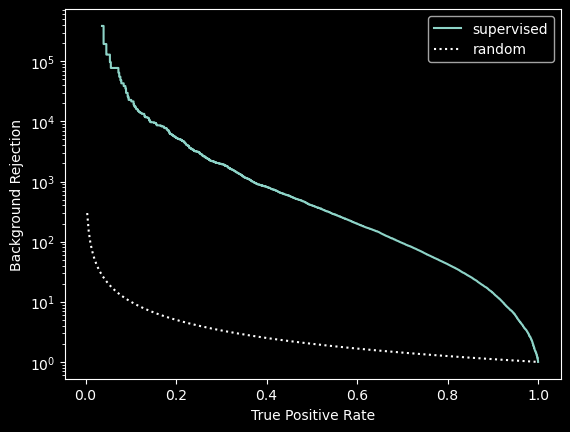

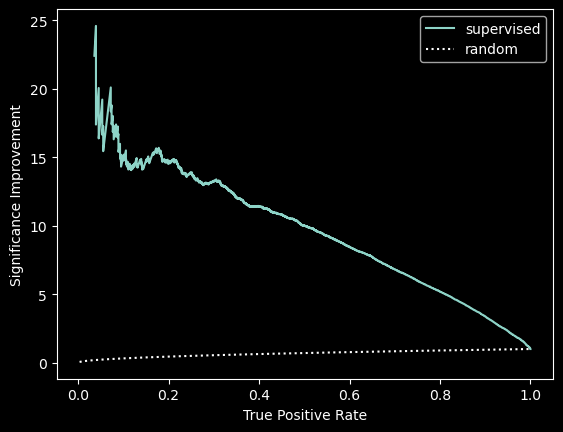

In [10]:
# now let's evaluate the signal extraction performance

clsf_test_set = np.vstack([innerdata_test,
                           innerdata_extrabkg_test,
                           innerdata_extrasig_test])

X_test = sup_scaler.transform(clsf_test_set[:, 1:-1])
y_test = clsf_test_set[:, -1]

preds_test = sup_classifier_model.predict(X_test)

with np.errstate(divide='ignore', invalid='ignore'):
    fpr, tpr, _ = roc_curve(y_test, preds_test)
    bkg_rej = 1 / fpr
    sic = tpr / np.sqrt(fpr)

    random_tpr = np.linspace(0, 1, 300)
    random_bkg_rej = 1 / random_tpr
    random_sic = random_tpr / np.sqrt(random_tpr)

# ROC curve
plt.plot(tpr, bkg_rej, label="supervised")
plt.plot(random_tpr, random_bkg_rej, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Background Rejection")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

# SIC curve
plt.plot(tpr, sic, label="supervised")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

This classifier clearly yields good separation between signal and background data.

Now we would like to move on to training an idealized anomaly detector. We just take the "data" with mostly background and a small fraction of signal, and train a classifier to distinguish it from a pure background sample.

In [11]:
# assigning label 1 to "data"
iad_clsf_train_data = innerdata_train.copy()
iad_clsf_train_data[:, -1] = np.ones_like(iad_clsf_train_data[:, -1])
iad_clsf_val_data = innerdata_val.copy()
iad_clsf_val_data[:, -1] = np.ones_like(iad_clsf_val_data[:, -1])

# and label 0 to background
iad_clsf_train_bkg = innerdata_extrabkg_train.copy()
iad_clsf_train_bkg[:, -1] = np.zeros_like(iad_clsf_train_bkg[:, -1])
iad_clsf_val_bkg = innerdata_extrabkg_val.copy()
iad_clsf_val_bkg[:, -1] = np.zeros_like(iad_clsf_val_bkg[:, -1])

# mixing together and shuffling
iad_clsf_train_set = np.vstack([iad_clsf_train_data, iad_clsf_train_bkg])
iad_clsf_val_set = np.vstack([iad_clsf_val_data, iad_clsf_val_bkg])
iad_clsf_train_set = shuffle(iad_clsf_train_set, random_state=42)
iad_clsf_val_set = shuffle(iad_clsf_val_set, random_state=42)

In [12]:
# either train new NN classifier to distinguish between "data" and background

iad_scaler = StandardScaler()
iad_scaler.fit(iad_clsf_train_set[:, 1:-1])

X_train = iad_scaler.transform(iad_clsf_train_set[:, 1:-1])
y_train = iad_clsf_train_set[:, -1]
X_val = iad_scaler.transform(iad_clsf_val_set[:, 1:-1])
y_val = iad_clsf_val_set[:, -1]

iad_classifier_savedir = "./trained_classifiers_idealized-ad_0/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(iad_classifier_savedir, "CLSF_models")):
    iad_classifier_model = NeuralNetworkClassifier(save_path=iad_classifier_savedir,
                                                   n_inputs=X_train.shape[1],
                                                   early_stopping=True, epochs=None,
                                                   verbose=True)
    iad_classifier_model.fit(X_train, y_train, X_val, y_val)
else:
    print(f"The model exists already in {iad_classifier_savedir}. Remove first if you want to overwrite.")


Epoch: 0


Train loss: 0.693263: 100%|██████████| 261375/261375 [00:05<00:00, 47182.54it/s]


Validation loss: 0.6930110061869902

Epoch: 1


Train loss: 0.693155: 100%|██████████| 261375/261375 [00:05<00:00, 50567.72it/s]


Validation loss: 0.6928875673343153

Epoch: 2


Train loss: 0.693099: 100%|██████████| 261375/261375 [00:05<00:00, 48882.97it/s]


Validation loss: 0.6933661835158572

Epoch: 3


Train loss: 0.693056: 100%|██████████| 261375/261375 [00:05<00:00, 50002.51it/s]


Validation loss: 0.6934899669359712

Epoch: 4


Train loss: 0.693048: 100%|██████████| 261375/261375 [00:05<00:00, 51805.02it/s]


Validation loss: 0.6926673139719403

Epoch: 5


Train loss: 0.692964: 100%|██████████| 261375/261375 [00:05<00:00, 51291.97it/s]


Validation loss: 0.6928565469734809

Epoch: 6


Train loss: 0.692884: 100%|██████████| 261375/261375 [00:04<00:00, 53401.48it/s]


Validation loss: 0.6926130902241258

Epoch: 7


Train loss: 0.692864: 100%|██████████| 261375/261375 [00:05<00:00, 51857.58it/s]


Validation loss: 0.692757020627751

Epoch: 8


Train loss: 0.692801: 100%|██████████| 261375/261375 [00:05<00:00, 50980.23it/s]


Validation loss: 0.6927048021379639

Epoch: 9


Train loss: 0.692752: 100%|██████████| 261375/261375 [00:05<00:00, 50299.52it/s]


Validation loss: 0.6925568773465998

Epoch: 10


Train loss: 0.692751: 100%|██████████| 261375/261375 [00:05<00:00, 50914.09it/s]


Validation loss: 0.6927424678031135

Epoch: 11


Train loss: 0.692710: 100%|██████████| 261375/261375 [00:05<00:00, 50507.81it/s]


Validation loss: 0.6924092732808169

Epoch: 12


Train loss: 0.692692: 100%|██████████| 261375/261375 [00:05<00:00, 50395.58it/s]


Validation loss: 0.6927579901674215

Epoch: 13


Train loss: 0.692678: 100%|██████████| 261375/261375 [00:04<00:00, 52397.87it/s]


Validation loss: 0.6923078252550434

Epoch: 14


Train loss: 0.692662: 100%|██████████| 261375/261375 [00:04<00:00, 53044.34it/s]


Validation loss: 0.6923610262134496

Epoch: 15


Train loss: 0.692626: 100%|██████████| 261375/261375 [00:04<00:00, 53257.25it/s]


Validation loss: 0.6925908791668275

Epoch: 16


Train loss: 0.692632: 100%|██████████| 261375/261375 [00:04<00:00, 54070.78it/s]


Validation loss: 0.6927492970929426

Epoch: 17


Train loss: 0.692622: 100%|██████████| 261375/261375 [00:05<00:00, 50618.28it/s]


Validation loss: 0.6924276731470052

Epoch: 18


Train loss: 0.692589: 100%|██████████| 261375/261375 [00:05<00:00, 49133.93it/s]


Validation loss: 0.6928675705019165

Epoch: 19


Train loss: 0.692620: 100%|██████████| 261375/261375 [00:05<00:00, 48911.43it/s]


Validation loss: 0.6924872026723974

Epoch: 20


Train loss: 0.692559: 100%|██████████| 261375/261375 [00:05<00:00, 51716.98it/s]


Validation loss: 0.6926507296807626

Epoch: 21


Train loss: 0.692533: 100%|██████████| 261375/261375 [00:05<00:00, 51317.50it/s]


Validation loss: 0.6927977480432567

Epoch: 22


Train loss: 0.692508: 100%|██████████| 261375/261375 [00:05<00:00, 47740.83it/s]


Validation loss: 0.6927929711692473

Epoch: 23


Train loss: 0.692527: 100%|██████████| 261375/261375 [00:05<00:00, 44139.43it/s]


Validation loss: 0.6926570782766622
Early stopping at epoch 23
Loading best model state...


In [13]:
# or alternatively load existing classifer model

iad_scaler = StandardScaler()
iad_scaler.fit(iad_clsf_train_set[:, 1:-1])

iad_classifier_savedir = "./trained_classifiers_idealized-ad_0/"
iad_classifier_model = NeuralNetworkClassifier(save_path=iad_classifier_savedir,
                                               n_inputs=iad_clsf_train_set[:, 1:-1].shape[1],
                                               load=True)

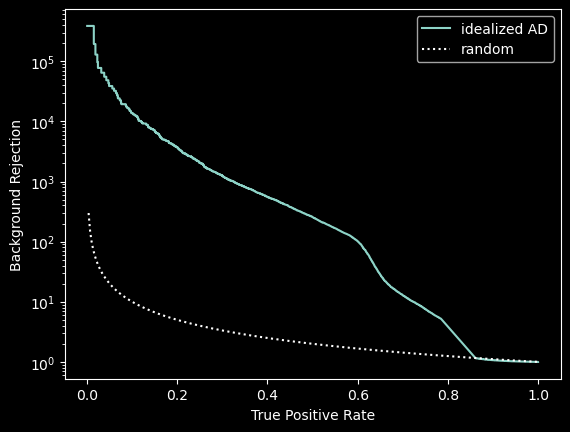

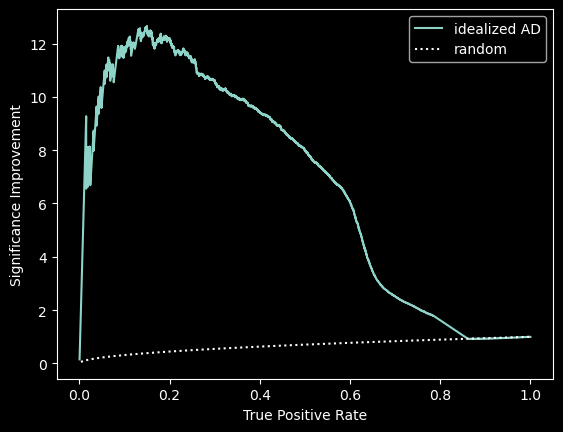

In [14]:
# now let's evaluate the signal extraction performance on the same test set

clsf_test_set = np.vstack([innerdata_test,
                           innerdata_extrabkg_test,
                           innerdata_extrasig_test])

X_test = iad_scaler.transform(clsf_test_set[:, 1:-1])
y_test = clsf_test_set[:, -1]

preds_test = iad_classifier_model.predict(X_test)

with np.errstate(divide='ignore', invalid='ignore'):
    fpr, tpr, _ = roc_curve(y_test, preds_test)
    bkg_rej = 1 / fpr
    sic = tpr / np.sqrt(fpr)

    random_tpr = np.linspace(0, 1, 300)
    random_bkg_rej = 1 / random_tpr
    random_sic = random_tpr / np.sqrt(random_tpr)

# ROC curve
plt.plot(tpr, bkg_rej, label="idealized AD")
plt.plot(random_tpr, random_bkg_rej, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Background Rejection")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

# SIC curve
plt.plot(tpr, sic, label="idealized AD")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

The plots above should also show quite good significance improvement, however a bit lower than in the fully supervised case. Under perfect training conditions, the two should be equal, but in practice we would need more and more training data with decreasing signal fractions to achieve this.

For the fun of it, let's compare the two approaches more thoroughly in terms of their signal extraction performance, rather than looking at two individual trainings. We will train ten classifiers each with the same data, then show their performance in terms of median and 68% confidence interval bands.

In [ ]:
# either train new NN classifiers to distinguish between signal and background

sup_scaler = StandardScaler()
sup_scaler.fit(sup_clsf_train_set[:, 1:-1])

X_train = sup_scaler.transform(sup_clsf_train_set[:, 1:-1])
y_train = sup_clsf_train_set[:, -1]
X_val = sup_scaler.transform(sup_clsf_val_set[:, 1:-1])
y_val = sup_clsf_val_set[:, -1]

sup_model_list = []
for i in range(10):
    _classifier_savedir = f"./trained_classifiers_supervised_{i}/"     
    sup_model_list.append(NeuralNetworkClassifier(save_path=_classifier_savedir,
                                                  n_inputs=X_train.shape[1],
                                                  early_stopping=True, epochs=None,
                                                  verbose=True))

    # We don't want to overwrite the model if it already exists.
    if not exists(join(_classifier_savedir, "CLSF_models")):
        sup_model_list[-1].fit(X_train, y_train, X_val, y_val)
    else:
        print(f"The model exists already in {_classifier_savedir}. Remove first if you want to overwrite. Loading its best state now.")
        sup_model_list[-1].load_best_model()

The model exists already in ./trained_classifiers_supervised_0/. Remove first if you want to overwrite. Loading its best state now.

Epoch: 0


Train loss: 0.247938: 100%|██████████| 302370/302370 [00:05<00:00, 51611.87it/s]


Validation loss: 0.22156860032089196

Epoch: 1


Train loss: 0.224462: 100%|██████████| 302370/302370 [00:05<00:00, 50802.31it/s]


Validation loss: 0.2221692972217396

Epoch: 2


Train loss: 0.221422: 100%|██████████| 302370/302370 [00:05<00:00, 52759.57it/s]


Validation loss: 0.22077891098655714

Epoch: 3


Train loss: 0.219659: 100%|██████████| 302370/302370 [00:05<00:00, 52626.55it/s]


Validation loss: 0.22093509258168517

Epoch: 4


Train loss: 0.218605: 100%|██████████| 302370/302370 [00:06<00:00, 45542.29it/s]


Validation loss: 0.21603109185483046

Epoch: 5


Train loss: 0.218529: 100%|██████████| 302370/302370 [00:07<00:00, 42434.04it/s]


Validation loss: 0.21766148402242905

Epoch: 6


Train loss: 0.217676: 100%|██████████| 302370/302370 [00:06<00:00, 43587.46it/s]


Validation loss: 0.2166179851646636

Epoch: 7


Train loss: 0.217009: 100%|██████████| 302370/302370 [00:07<00:00, 42171.94it/s]


Validation loss: 0.2157922282530244

Epoch: 8


Train loss: 0.216574: 100%|██████████| 302370/302370 [00:07<00:00, 41535.42it/s]


Validation loss: 0.21952276255484598

Epoch: 9


Train loss: 0.216062: 100%|██████████| 302370/302370 [00:06<00:00, 46072.87it/s]


Validation loss: 0.21575612354620247

Epoch: 10


Train loss: 0.215782: 100%|██████████| 302370/302370 [00:05<00:00, 51577.91it/s]


Validation loss: 0.21473177486828937

Epoch: 11


Train loss: 0.215564: 100%|██████████| 302370/302370 [00:06<00:00, 50270.13it/s]


Validation loss: 0.21490293946235803

Epoch: 12


Train loss: 0.214946: 100%|██████████| 302370/302370 [00:05<00:00, 52880.32it/s]


Validation loss: 0.2155356988880285

Epoch: 13


Train loss: 0.214765: 100%|██████████| 302370/302370 [00:05<00:00, 52498.72it/s]


Validation loss: 0.21718212674567655

Epoch: 14


Train loss: 0.214272: 100%|██████████| 302370/302370 [00:05<00:00, 53038.82it/s]


Validation loss: 0.21450261577109622

Epoch: 15


Train loss: 0.214012: 100%|██████████| 302370/302370 [00:05<00:00, 52229.57it/s]


Validation loss: 0.2126069808746599

Epoch: 16


Train loss: 0.213922: 100%|██████████| 302370/302370 [00:05<00:00, 52719.54it/s]


Validation loss: 0.21357925423201482

Epoch: 17


Train loss: 0.213305: 100%|██████████| 302370/302370 [00:05<00:00, 52414.67it/s]


Validation loss: 0.2147453843787977

Epoch: 18


Train loss: 0.213356: 100%|██████████| 302370/302370 [00:06<00:00, 49243.36it/s]


Validation loss: 0.21308809460917855

Epoch: 19


Train loss: 0.213591: 100%|██████████| 302370/302370 [00:05<00:00, 52065.97it/s]


Validation loss: 0.21386540475165008

Epoch: 20


Train loss: 0.213225: 100%|██████████| 302370/302370 [00:05<00:00, 51785.35it/s]


Validation loss: 0.21248400590981648

Epoch: 21


Train loss: 0.212919: 100%|██████████| 302370/302370 [00:05<00:00, 51356.01it/s]


Validation loss: 0.21368890082950046

Epoch: 22


Train loss: 0.212752: 100%|██████████| 302370/302370 [00:05<00:00, 51499.87it/s]


Validation loss: 0.2132698570846752

Epoch: 23


Train loss: 0.212720: 100%|██████████| 302370/302370 [00:05<00:00, 53127.41it/s]


Validation loss: 0.2126478719673339

Epoch: 24


Train loss: 0.212551: 100%|██████████| 302370/302370 [00:05<00:00, 51414.53it/s]


Validation loss: 0.21605441889185814

Epoch: 25


Train loss: 0.212591: 100%|██████████| 302370/302370 [00:05<00:00, 51725.03it/s]


Validation loss: 0.21344435222589286

Epoch: 26


Train loss: 0.212701: 100%|██████████| 302370/302370 [00:06<00:00, 50236.86it/s]


Validation loss: 0.2136950754625782

Epoch: 27


Train loss: 0.212475: 100%|██████████| 302370/302370 [00:05<00:00, 53820.45it/s]


Validation loss: 0.2132566341074409

Epoch: 28


Train loss: 0.212241: 100%|██████████| 302370/302370 [00:05<00:00, 52992.51it/s]


Validation loss: 0.2146576348573539

Epoch: 29


Train loss: 0.212125: 100%|██████████| 302370/302370 [00:05<00:00, 53984.18it/s]


Validation loss: 0.21348909505992938

Epoch: 30


Train loss: 0.212182: 100%|██████████| 302370/302370 [00:05<00:00, 51296.79it/s]


Validation loss: 0.21417285885400833
Early stopping at epoch 30
Loading best model state...

Epoch: 0


Train loss: 0.245208: 100%|██████████| 302370/302370 [00:05<00:00, 53328.54it/s]


Validation loss: 0.22945588614530624

Epoch: 1


Train loss: 0.223401: 100%|██████████| 302370/302370 [00:05<00:00, 51938.60it/s]


Validation loss: 0.22080663286956254

Epoch: 2


Train loss: 0.221195: 100%|██████████| 302370/302370 [00:05<00:00, 50854.57it/s]


Validation loss: 0.21958027431729493

Epoch: 3


Train loss: 0.219851: 100%|██████████| 302370/302370 [00:05<00:00, 51673.71it/s]


Validation loss: 0.21751162163960705

Epoch: 4


Train loss: 0.218753: 100%|██████████| 302370/302370 [00:06<00:00, 49163.78it/s]


Validation loss: 0.21617368305944334

Epoch: 5


Train loss: 0.215016:  43%|████▎     | 128896/302370 [00:02<00:03, 47748.60it/s]

In [ ]:
# or alternatively load existing classifer models

sup_scaler = StandardScaler()
sup_scaler.fit(sup_clsf_train_set[:, 1:-1])

sup_model_list = []
for i in range(10):
    _classifier_savedir = f"./trained_classifiers_supervised_{i}/"     
    sup_model_list.append(NeuralNetworkClassifier(save_path=_classifier_savedir,
                                                  n_inputs=sup_clsf_train_set[:, 1:-1].shape[1],
                                                  load=True))

In [ ]:
# the same goes for the IAD: either train from scratch

iad_scaler = StandardScaler()
iad_scaler.fit(iad_clsf_train_set[:, 1:-1])

X_train = iad_scaler.transform(iad_clsf_train_set[:, 1:-1])
y_train = iad_clsf_train_set[:, -1]
X_val = iad_scaler.transform(iad_clsf_val_set[:, 1:-1])
y_val = iad_clsf_val_set[:, -1]

iad_model_list = []
for i in range(10):
    _classifier_savedir = f"./trained_classifiers_idealized-ad_{i}/"     
    iad_model_list.append(NeuralNetworkClassifier(save_path=_classifier_savedir,
                                                  n_inputs=X_train.shape[1],
                                                  early_stopping=True, epochs=None,
                                                  verbose=True))

    # We don't want to overwrite the model if it already exists.
    if not exists(join(_classifier_savedir, "CLSF_models")):
        iad_model_list[-1].fit(X_train, y_train, X_val, y_val)
    else:
        print(f"The model exists already in {_classifier_savedir}. Remove first if you want to overwrite. Loading its best state now.")
        iad_model_list[-1].load_best_model()

In [ ]:
# or alternatively load existing IAD models

iad_scaler = StandardScaler()
iad_scaler.fit(iad_clsf_train_set[:, 1:-1])

iad_model_list = []
for i in range(10):
    _classifier_savedir = f"./trained_classifiers_idealized-ad_{i}/"     
    iad_model_list.append(NeuralNetworkClassifier(save_path=_classifier_savedir,
                                                  n_inputs=iad_clsf_train_set[:, 1:-1].shape[1],
                                                  load=True))

In [ ]:
# now let's evaluate all models and compute their median ROC and SIC, as well as 68% bands

clsf_test_set = np.vstack([innerdata_test,
                           innerdata_extrabkg_test,
                           innerdata_extrasig_test])

# we will infeer all ROC and SIC values onto a common TPR grid
common_tpr = np.linspace(0, 1, 300)

X_test_sup = sup_scaler.transform(clsf_test_set[:, 1:-1])
y_test_sup = clsf_test_set[:, -1]

# first supervised classifiers
sup_bkg_rejs = []
sup_sics = []
for model in sup_model_list:
    preds_test = model.predict(X_test_sup)
    with np.errstate(divide='ignore', invalid='ignore'):
        fpr, tpr, _ = roc_curve(y_test, preds_test)
        sup_bkg_rejs.append(np.interp(common_tpr, tpr, 1/fpr))
        sup_sics.append(np.interp(common_tpr, tpr, tpr / np.sqrt(fpr)))

# then the same with the IAD
X_test_iad = iad_scaler.transform(clsf_test_set[:, 1:-1])
y_test_iad = clsf_test_set[:, -1]

iad_bkg_rejs = []
iad_sics = []
for model in iad_model_list:
    preds_test = model.predict(X_test_iad)
    with np.errstate(divide='ignore', invalid='ignore'):
        fpr, tpr, _ = roc_curve(y_test, preds_test)
        iad_bkg_rejs.append(np.interp(common_tpr, tpr, 1/fpr))
        iad_sics.append(np.interp(common_tpr, tpr, tpr / np.sqrt(fpr)))

with np.errstate(divide='ignore', invalid='ignore'):
    random_bkg_rej = 1 / common_tpr
    random_sic = common_tpr / np.sqrt(common_tpr)

# ROC curves
plt.plot(common_tpr,
         np.median(np.stack(sup_bkg_rejs, axis=0), axis=0),
         label="supervised")
plt.fill_between(common_tpr,
                 np.quantile(np.stack(sup_bkg_rejs, axis=0), q=.16, axis=0),
                 np.quantile(np.stack(sup_bkg_rejs, axis=0), q=.84, axis=0),
                 color=plt.gca().lines[-1].get_color(),
                 alpha=0.3)
plt.plot(common_tpr,
         np.median(np.stack(iad_bkg_rejs, axis=0), axis=0),
         label="idealized AD")
plt.fill_between(common_tpr,
                 np.quantile(np.stack(iad_bkg_rejs, axis=0), q=.16, axis=0),
                 np.quantile(np.stack(iad_bkg_rejs, axis=0), q=.84, axis=0),
                 color=plt.gca().lines[-1].get_color(),
                 alpha=0.3)
plt.plot(common_tpr, random_bkg_rej, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Background Rejection")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

# SIC curves
plt.plot(common_tpr,
         np.median(np.stack(sup_sics, axis=0), axis=0),
         label="supervised")
plt.fill_between(common_tpr,
                 np.quantile(np.stack(sup_sics, axis=0), q=.16, axis=0),
                 np.quantile(np.stack(sup_sics, axis=0), q=.84, axis=0),
                 color=plt.gca().lines[-1].get_color(),
                 alpha=0.3)
plt.plot(common_tpr,
         np.median(np.stack(iad_sics, axis=0), axis=0),
         label="idealized AD")
plt.fill_between(common_tpr,
                 np.quantile(np.stack(iad_sics, axis=0), q=.16, axis=0),
                 np.quantile(np.stack(iad_sics, axis=0), q=.84, axis=0),
                 color=plt.gca().lines[-1].get_color(),
                 alpha=0.3)
plt.plot(common_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

We see that the IAD is not as good as the supervised classifier here. For that we would probably need much more training data. Also, one sees that the supervised classifier has almost negligible variance in performance, whereas the IAD varies from run to run more. It makes sense as there is only a small number of signal events in the training data.

However, the IAD still performs pretty well and comes increasingly close to a fully supervised model at tight cuts. This is remarkable, as there was no explicit signal information provided to the classifier during the training.